# Connecting painters based on their locations throughout time

## Imports, initial procedures

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

url = "https://raw.githubusercontent.com/me9hanics/PainterPalette/main/PainterPalette.csv"
artists = pd.read_csv(url).drop(columns=["Type", "Contemporary"])#Type and contemporary are "artificial" columns

In [2]:
artists[10:15]

,artist,Nationality,citizenship,gender,styles,movement,Art500k_Movements,birth_place,death_place,birth_year,...,occupations,PaintingsExhibitedAt,PaintingsExhibitedAtCount,PaintingSchool,Influencedby,Influencedon,Pupils,Teachers,FriendsandCoworkers,ArtMovement
10,Friedrich Schroder-Sonnenstern,German,Germany,male,Art Brut,Outsider art (Art brut),{Outsider art (Art brut):10},Sovetsk,Berlin,1892.0,...,"painter, drawer",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,D. Jeffrey Mims,American,United States of America,male,Contemporary Realism,Classical Realism,{Classical Realism:10},North Carolina,NaN,1954.0,...,"painter, politician",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,Nuno Gonçalves,Portuguese,Kingdom of Portugal,male,Early Renaissance,Early Renaissance,{Early Renaissance:10},NaN,NaN,1425.0,...,"portraitist, painter, musician, researcher","Lisbon, Portugal","{Lisbon:1},{Portugal:1}",NaN,"National Museum of Ancient Art (MNAA), Lisbon,...",NaN,NaN,NaN,NaN,NaN
13,Alexander Khvostenko-Khvostov,"Russian,Ukrainian",Russian Empire,male,"Art Nouveau (Modern), Constructivism, Expressi...",Avant-garde,"{Avant-garde,Constructivism:21}","Borisovka, Borisovsky District, Belgorod Oblast",Kyiv,1885.0,...,"visual artist, scenographer, graphic artist, p...",NaN,NaN,ARMU (Association of Revolutionary Masters of ...,NaN,NaN,NaN,"Aleksandra Ekster,","Victor Palmov,David Burliuk,Oleksandr Bogomazo...",NaN
14,Jose Ferraz de Almeida Junior,Brazilian,Brazil,male,"Academicism, Realism",Realism,{Realism:64},Itu,Piracicaba,1850.0,...,painter,"Brazil, Rio de Janeiro, Sao Paulo","{Sao Paulo:30},{Brazil:36},{Rio de Janeiro:4}",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
artists.columns

Index(['artist', 'Nationality', 'citizenship', 'gender', 'styles', 'movement',
       'Art500k_Movements', 'birth_place', 'death_place', 'birth_year',
       'death_year', 'FirstYear', 'LastYear', 'wikiart_pictures_count',
       'locations', 'locations_with_years', 'styles_extended', 'StylesCount',
       'StylesYears', 'occupations', 'PaintingsExhibitedAt',
       'PaintingsExhibitedAtCount', 'PaintingSchool', 'Influencedby',
       'Influencedon', 'Pupils', 'Teachers', 'FriendsandCoworkers',
       'ArtMovement'],
      dtype='object')

We need only the locations (possibly exhibitions) of painters

## Analysis:

### "Time-and-place" painters network:

To connect painters based on their locations, I created a time "index" (measure of similarity) and a place index for each painter pair, and if these values and their product are higher than given thresholds, then a link is created between to painters.

The main attributes:

- place of birth
- places
- places by years
- nationality
- years of birth, first and last painting's year in the dataset

In [3]:
import httpimport

with httpimport.remote_repo('https://raw.githubusercontent.com/me9hanics/ArtProject/main/'):
    import analysis_functions

**Year index between two artists:**

Measure of how close two artists were in time. The closer they were, the higher the value. The value is calculated as follows:<br>
Firstly, count the number of years the two artists were alive at the same time (called count). For either artist, if a year is between his birthyear and first year of painting appearing in the dataset, instead of adding 1 year to the count, we add 0.1 (and in the case when this is true for both artists, add 0.01 instead).<br>
In the end, we divide the count by the lifespan of the artist who lived less. This is because if we just took the average of the two  painters' lifespan, painters who lived for a longer time would have too many high indices. Sure, we can say that a painter who lived longer likely met more painters, but just this is not the point, the point is rather that if you take a painter who lived for a short time and a painter who lived for a long time, the longer living painter's lengthy lifetime typically shouldn't be a factor of the probability of the shorter living painter meeting him. Painter X who died at age 30 and had a 10-year span to meet other painters is equally likely to have met Painter Y who lived for 10 years more after Painter X's death, as Painter Z who lived for 30 more years after Painter X died. The increase of amount of painters met should only come from having longer overlapping periods with more artists (from living longer). On the other hand, lifespan should somehow be also accounted, because if not (if we just divide by a number like 100, or don't divide at all), short living painters (like the short-lived Viennese Egon Schiele, who is a very influential painter despite having lived only 28 years) would have likely no connections in the graph, which is why their age should be accounted for somehow. This is why we divide by the shorter living painter's lifespan, which is still enough to have that longer living painters have more connections.<br>

**Place index between two artists:**

Measure for how close are two artists to each other in terms of places they lived/painted in and nationality. Originally, birthplace was also a factor, but it uses GeoPy's Nominatim, and running it on the full data tends to make it time out. <br>

<details> <summary><u>Function for birthplaces</u></summary>

```python

from geopy.geocoders import Nominatim    
geolocator = Nominatim(user_agent="PainterProject")

# Function to get the country from a birthplace
def get_country(birthplace):
    location = geolocator.geocode(birthplace)
    if location:
        return location.address.split(",")[-1].strip()
    return None

```

</details>

Finally create the time and place network:

In [4]:
import ast #string to list/dict functionality is included in it

In [5]:
import numpy as np

def years_fixer(years): #Birth, first active year, last active year, death
    if np.isnan(years[0]) and np.isnan(years[1]):
        return np.nan
    if np.isnan(years[2]) and np.isnan(years[3]):
        return np.nan
    
    if np.isnan(years[0]):
        years[0] = years[1]-20
    if np.isnan(years[1]):
        years[1] = years[0]+20
    if np.isnan(years[2]):
        years[2] = years[3]
    if np.isnan(years[3]):
        years[3] = years[2]

    #Sort just in case
    return sorted(years)

Precomputing (lookup speed could be faster than computing in each step, because dicts are faster than (Pandas) dataframes etc.):

In [6]:
#Geographical / time data
#['birth_place', 'death_place', 'Nationality','locations','locations_with_years' , 'birth_year','death_year' , 'FirstYear','LastYear','citizenship']

#Artist data instances (pandas series)
artist_data = {artist: artists[artists['artist']==artist].iloc[0] for artist in artists['artist']}

#Birthyear, first active year (Art500k), last active year, death year
years = {artist: years_fixer([data['birth_year'], data['FirstYear'], data['LastYear'], data['death_year']]) for artist, data in artist_data.items()}

nationalities = {artist: np.nan if type(data['Nationality']) != str
                 else data['Nationality'].split(",") for artist, data in artist_data.items()}
places = {artist: [] if pd.isnull(data['locations'])
          else ast.literal_eval(data['locations']) for artist, data in artist_data.items()}#Literal eval to convert string to list

In [7]:
import itertools
G0 = nx.Graph(); G0.add_nodes_from(artists['artist'])

#Appearantly, itertools.combinations is faster than nested for loops (probably because you precalculate the combinations)
for artist1, artist2 in itertools.combinations(artists['artist'], 2):
    artist1_data = artist_data[artist1]
    artist2_data = artist_data[artist2]
    
    years1 = years[artist1]
    years2 = years[artist2]
    
    if type(years1) != list or type(years2) != list: #np.nan
        continue

    birthplace1 = artist1_data["birth_place"]
    birthplace2 = artist2_data["birth_place"]
    
    nationalities1 = nationalities[artist1]
    nationalities2 = nationalities[artist2]
    
    citizenship1 = artist1_data['citizenship']
    citizenship2 = artist2_data['citizenship']
    
    places1_list = places[artist1]
    places2_list = places[artist2]
    
    index_val = analysis_functions.index_simple(places1_list, places2_list, years1, years2, birthplace1, birthplace2, nationalities1, nationalities2, citizenship1, citizenship2, active_years_only=True)
    
    if (index_val > 0):
        G0.add_edge(artist1, artist2, weight=index_val)
        nx.set_edge_attributes(G0, {(artist1, artist2): index_val}, 'index_value')

In [8]:
#Save G0 as a gexf file
nx.write_gexf(G0, "../networks/painter_location_graph.gexf")
nx.write_graphml(G0, "../networks/painter_location_graph.graphml")

In [9]:
#Print number of nodes and edges
print("Number of nodes: ", G0.number_of_nodes())
print("Number of edges: ", G0.number_of_edges())

Number of nodes:  10549
Number of edges:  422861


In [15]:
edge_weights_list = sorted([G0[u][v]['weight'] for u,v in G0.edges])

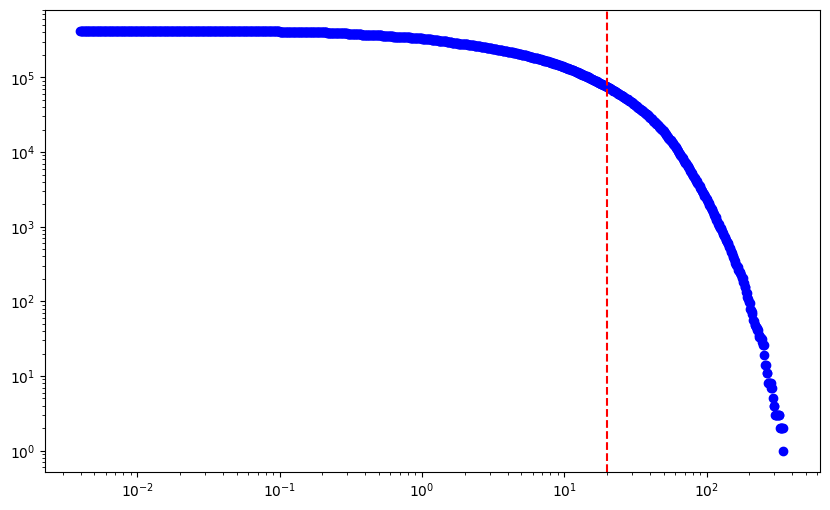

In [31]:
#Plot: for different threshold, how many edges would we have if we only consider edges with weight above that threshold
plt.figure(figsize=(10,6))
for i in np.logspace(-2.4, 2.55, 1000):
    more_than_threshold = sum([1 for weight in edge_weights_list if weight >= i])
    plt.scatter(i, more_than_threshold, color='blue')

plt.yscale('log')
plt.xscale('log')
plt.axvline(x=20, color='red', linestyle='--')

In [32]:
sum([1 for weight in edge_weights_list if weight >= 20])

74981

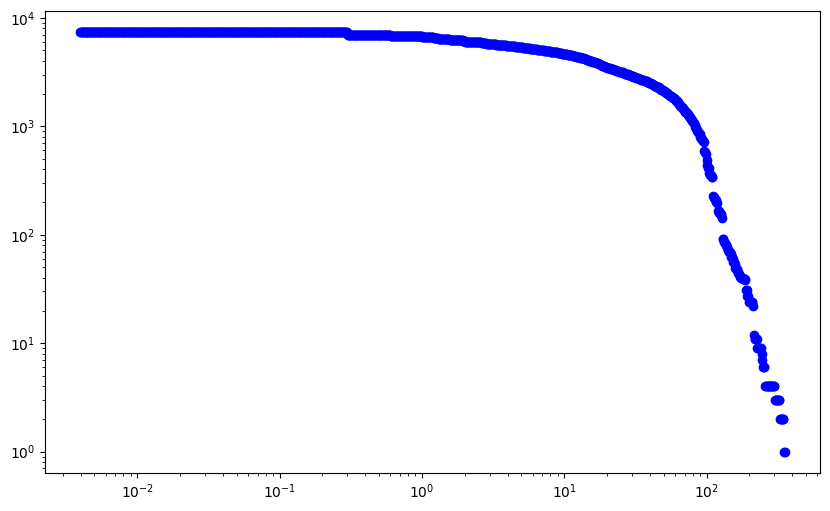

In [37]:
#Percolation plot: for different threshold, how many nodes are there in the largest connected component?
plt.figure(figsize=(10,6))
for i in np.logspace(-2.4, 2.55, 1000):
    G0_copy = G0.copy()
    for u,v in G0_copy.edges:
        if G0_copy[u][v]['weight'] < i:
            G0_copy.remove_edge(u,v)
    components = list(nx.connected_components(G0_copy))
    largest_component = max(components, key=len)
    plt.scatter(i, len(largest_component), color='blue')

plt.yscale('log')
plt.xscale('log')

In [34]:
#Min and max edge weights
print("Min edge weight: ", min([G0.edges[edge]['weight'] for edge in G0.edges]))
print("Max edge weight: ", max([G0.edges[edge]['weight'] for edge in G0.edges]))

Min edge weight:  0.004545454545454545
Max edge weight:  349.59999999999997


In [36]:
#Print top 25 edge weights
sorted_edges = sorted(G0.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)
for edge in sorted_edges[:50]:
    print(edge[0],"and", edge[1], edge[2]['weight'])
    

Sarah Purser and Robert Hunter 349.59999999999997
Man and Vettor Pisani 345.3333333333333
Tintoretto and Vettor Pisani 326.59999999999997
Corneille and Man 301.25
Arthur Hughes and William Shakespeare Burton 294.4
Leon Wyczółkowski and Leon Wyczolkowski 289.79999999999995
Louis Carrogis and Antoine de Marcenay de Ghuy 289.79999999999995
Dusan Dzamonja and Dušan Džamonja 285.2
Eduard von Gebhardt and Eduard Von Gebhardt 266.79999999999995
Felix Nadar and Nadar 266.79999999999995
Jean Baptiste Claude Odiot and Adèle Romany 266.79999999999995
Marcus Stone and William Shakespeare Burton 262.2
Antoine-François Callet and Felix Lecomte 262.2
Richard Avedon and Paul Cadmus 262.2
Jean Victor Bertin and Jean Baptiste Claude Odiot 257.59999999999997
Samuel De Wilde and James Heath 257.59999999999997
Isaac Walraven and Paulus Bramer 257.59999999999997
Girolamo Forabosco and Vettor Pisani 257.59999999999997
Corneille and Joseph Charles Marin 255.85
Arthur Hughes and Marcus Stone 254.79999999999995

In [22]:
cols = ['artist','birth_place', 'death_place', 'locations', 'birth_year', 'death_year', 'FirstYear', 'LastYear']

In [30]:
artists[(artists['artist'].str.contains("Odiot")) | (artists['artist'] == "Adèle Romany")][cols]

,artist,birth_place,death_place,locations,birth_year,death_year,FirstYear,LastYear
8215,Jean Baptiste Claude Odiot,Paris,Paris,['Paris'],1763.0,1850.0,NaN,NaN
8249,Charles Nicolas Odiot,Paris,8th arrondissement of Paris,[],1789.0,1868.0,NaN,NaN
10171,Adèle Romany,Paris,Paris,['Paris'],1769.0,1846.0,NaN,NaN
